# Исследование DFS(Deep Feature Selection) метода отбора признаков

Необходимые библиотеки **PyTorch**, **Scikit-learn**, **NumPy** и **Matplotlib**

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data as torch_data_utils

import sklearn as sk
from sklearn import metrics
from sklearn import utils
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
from sklearn import preprocessing

import numpy as np

from matplotlib import pyplot as plt

Гиперпараметры эксперимента

In [2]:
# параметры обучающей выборки
num_features = 1524 # исходное число признаков
num_classes = 2 # число классов
class_labels = list(range(num_classes)) # метки классов

# параметры обучения модели DFS
dfs_num_epochs = 500
dfs_lr = 5e-3
dfs_lr_patience = 50
dfs_lr_cooldown = 15
dfs_lr_decay_factor = 0.1

# Коэффиценты регуляризации DFS
dfs_lambda_1 = 2e-4
dfs_lambda_2 = 0.9
dfs_alpha_1 = 5e-5
dfs_alpha_2 = 0.1

Определим модель *DFS*. Модель принимает на вход тензор *(batch, num_features)*, а возвращает тензор размерности *(batch, num_classes)*.

После того как модель будет обучена *коэффиценты* слоя ***w*** будут показывать важность признаков и если их отсортировать по убыванию, то можно выбрать из *num_features* признаков первые ***k*** штук, которые являются самыми важными по мнению модели.

Таким образом с помощью обученной модели можно проводить отбор признаков для данной задачи.

In [3]:
class DeepDFS(nn.Module):
    def __init__(self):
        super(DeepDFS, self).__init__()
        
        self.w = nn.Parameter(torch.empty(num_features))
        nn.init.uniform_(self.w, a=0, b=1)
        
        self.W1 = nn.Linear(in_features=num_features, out_features=512)
        self.W2 = nn.Linear(in_features=512, out_features=128)
        self.W3 = nn.Linear(in_features=128, out_features=num_classes)
    
    def forward(self, x):
        result = torch.mul(self.w, x)
        
        result = torch.tanh(self.W1(result))
        result = torch.tanh(self.W2(result))
        result = self.W3(result)
        
        return result

Для удобства обучения модели *PyTorch* определим вспомогательный класс обучающей выборки

In [4]:
class DFSExperimentDataSet(torch_data_utils.Dataset):
    def __init__(self, data, labels):        
        self.data = torch.tensor(data, dtype=torch.float)
        self.labels = torch.tensor(labels)
        
        self.length = self.data.shape[0]
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        feature = self.data[idx]
        label = self.labels[idx]
        
        return feature, label
    
    def get_labels(self):
        return self.labels

Одно из отличий **DFS** в *функции ошибки*, т.к. используется *ElasticNet* регуляризация. Определим функцию ошибки для обучения модели.

In [5]:
def DFSLoss(outputs, labels, model, class_weights=None):
    l = F.cross_entropy(outputs, labels, reduction='mean', weight=class_weights)
    
    l1_w = dfs_lambda_2 * torch.norm(model.w, 1)
    l2_w = (1 - dfs_lambda_2) / 2 * torch.pow(torch.norm(model.w, 2), 2)
    
    l1_W = dfs_alpha_2 * (
        torch.norm(model.W1.weight, 1) + \
        torch.norm(model.W2.weight, 1) + \
        torch.norm(model.W3.weight, 1)
    )
    
    l2_W = (1 - dfs_alpha_2) / 2 * (
        torch.pow(torch.norm(model.W1.weight, p='fro'), 2) + \
        torch.pow(torch.norm(model.W2.weight, p='fro'), 2) + \
        torch.pow(torch.norm(model.W3.weight, p='fro'), 2)
    )
    
    return l + dfs_lambda_1 * (l1_w + l2_w) + dfs_alpha_1 * (l1_W + l2_W)

Далее следует тренировка модели

In [6]:
DFSModel = DeepDFS()

raw_data = np.loadtxt('train.csv', delimiter=',', skiprows=1)

# X, y - признаки и метки классов
X, y = raw_data[:, :-1], raw_data[:, -1].astype(int)

class_weights = utils.class_weight.compute_class_weight('balanced', class_labels, y)
class_weights_t = torch.tensor(class_weights, dtype=torch.float)

# X_train, y_train - признаки и метки классов для обучения
# X_test, y_test - признаки и метки классов для тестирования
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                                                    test_size=0.1, shuffle=True, stratify=y)

scaler = preprocessing.StandardScaler(copy=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

dfs_train_data_set = DFSExperimentDataSet(X_train, y_train)
dfs_test_data_set = DFSExperimentDataSet(X_test, y_test)

dfs_train_loader = torch_data_utils.DataLoader(dfs_train_data_set, batch_size=24, shuffle=True)
dfs_test_loader = torch_data_utils.DataLoader(dfs_test_data_set, batch_size=1, shuffle=False)

dfs_optimizer = torch.optim.Adam(DFSModel.parameters(), lr=dfs_lr)
dfs_lr_sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(dfs_optimizer, mode='max', 
                                                         factor=dfs_lr_decay_factor,
                                                         patience=dfs_lr_patience,
                                                         cooldown=dfs_lr_cooldown)

In [7]:
max_dfs_accuracy = 0.0 # лучшая точность
min_dfs_loss = float('inf') # минимальные потери

best_dfs_epoch = 0 # лучшая эпоха
best_dfs_sd = DFSModel.state_dict() # веса модели для лучшей эпохи

for epoch in range(dfs_num_epochs):
    total_loss = 0.0
    for data in dfs_train_loader:
        inputs, labels = data
        outputs = DFSModel(inputs)
                
        dfs_optimizer.zero_grad()
        loss = DFSLoss(outputs, labels, DFSModel, class_weights_t)
        loss.backward()
        dfs_optimizer.step()
        
        total_loss += loss
    
    # Валидация
    correct = []
    predicted = []
    DFSModel.eval()
    with torch.no_grad():
        for data in dfs_test_loader:
            inputs, labels = data
            outputs = DFSModel(inputs)
            predicted += torch.argmax(outputs, dim=1).tolist()
            correct += labels.tolist()

    accuracy = metrics.accuracy_score(correct, predicted)
    
    if accuracy > max_dfs_accuracy or \
    (accuracy==max_dfs_accuracy and total_loss < min_dfs_loss):
        max_dfs_accuracy = accuracy
        min_dfs_loss = total_loss
        
        best_dfs_epoch = epoch + 1
        best_dfs_sd = DFSModel.state_dict()
        
    print(f'''epoch [{epoch + 1}, {dfs_num_epochs}] \
    accuracy {accuracy} max {max_dfs_accuracy} total loss {total_loss}''')
    
    dfs_lr_sheduler.step(accuracy)
    
    DFSModel.train()
    
print(f'Finish. best accuracy {max_dfs_accuracy} and loss {min_dfs_loss} on epoch {best_dfs_epoch}')

DFSModel.load_state_dict(best_dfs_sd)
DFSModel.eval()
torch.save(DFSModel.state_dict(), 'DFSModel_SD.pt')

epoch [1, 500]     accuracy 0.6306306306306306 max 0.6306306306306306 total loss 29.731109619140625
epoch [2, 500]     accuracy 0.7837837837837838 max 0.7837837837837838 total loss 24.22406768798828
epoch [3, 500]     accuracy 0.8288288288288288 max 0.8288288288288288 total loss 20.92525863647461
epoch [4, 500]     accuracy 0.8198198198198198 max 0.8288288288288288 total loss 19.37071418762207
epoch [5, 500]     accuracy 0.8108108108108109 max 0.8288288288288288 total loss 18.076066970825195
epoch [6, 500]     accuracy 0.8288288288288288 max 0.8288288288288288 total loss 16.589069366455078
epoch [7, 500]     accuracy 0.8378378378378378 max 0.8378378378378378 total loss 14.248830795288086
epoch [8, 500]     accuracy 0.8468468468468469 max 0.8468468468468469 total loss 13.527902603149414
epoch [9, 500]     accuracy 0.8468468468468469 max 0.8468468468468469 total loss 12.412858009338379
epoch [10, 500]     accuracy 0.8378378378378378 max 0.8468468468468469 total loss 13.034048080444336
ep

Отсортируем по *убыванию* **абсолютные** значения слоя ***w***

In [8]:
dfs_importance_features = [(abs(val), idx[0]) for idx, val in np.ndenumerate(DFSModel.w.data.numpy())]
dfs_importance_features.sort(key=lambda x: x[0], reverse=True)

Просмотрим *5* первых и последних по важности признаков.

- Первый элемент - относительная важность по мнению модели
- Второй элемент - индекс признака

In [9]:
print(dfs_importance_features[:5])
print(dfs_importance_features[-5:-1])

[(1.3727762, 866), (1.1851319, 511), (1.1723036, 582), (1.1450237, 1088), (1.1357777, 805)]
[(1.9354518e-12, 1035), (1.7400525e-12, 400), (5.897713e-13, 1323), (5.713763e-13, 1319)]


Т.к. значения весов не важны оставим только соответствующие индексы признаков

In [10]:
dfs_importance_features = [feature[1] for feature in dfs_importance_features]

В качестве моделей выбора признаков для сравнения будем использовать традиционный *LASSO* и *RandomForest*.

Подберём гиперпараметры для данных моделей и выберем лучшие по кросс-валидации.

In [11]:
cv = model_selection.ShuffleSplit(n_splits=3, test_size=0.15)

param_grid = {
    'alpha': [10, 1.0, 0.7, 0.5, 0.3],
    'selection' : ['cyclic', 'random']
}

gs = model_selection.GridSearchCV(linear_model.Lasso(), param_grid, cv=cv, n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)

# LASSO модель для отбора признаков
best_lasso_select = gs.best_estimator_

param_grid = {
    'n_estimators' : [50, 150, 500],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [5, 10, 25]
}

gs = model_selection.GridSearchCV(ensemble.RandomForestClassifier(class_weight='balanced'), 
                                  param_grid, cv=cv, n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)

# RandomForest модель для отбора признаков
best_rf_select = gs.best_estimator_

# гиперпараметры для RandomForest
best_rf_params = gs.best_params_

Теперь выберем гиперпараметры для финальных моделей по кросс валидации. Затем будем использовать финальные модели с полученными гиперпараметрами для обучения и тестирования на различном *количестве* **признаков** отобранных методами описанами выше + *DFS*

Будем использовать *RandomForest*, *LogisticRegression* и *SVM*. RandomForest возьмём из предыдущего шага.

In [12]:
param_grid = {
    'C' : [10, 1.0, 0.7, 0.5, 0.3],
    'kernel' : ['rbf', 'poly', 'sigmoid']
}

gs = model_selection.GridSearchCV(svm.SVC(class_weight='balanced', gamma='auto'), 
                                  param_grid, cv=cv, n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)

# гиперпараметры для SVM
best_svc_params = gs.best_params_

param_grid = {
    'C' : [10, 1.0, 0.7, 0.5, 0.3],
    'penalty' : ['l1', 'l2']
}

gs = model_selection.GridSearchCV(linear_model.LogisticRegression(class_weight='balanced', solver='liblinear'), 
                                  param_grid, cv=cv, n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)

# гиперпараметры для LogisticRegression
best_lr_params = gs.best_params_

Теперь будем перебирать различное количество признаков.

1. Далее выбираем данное количество с помощью *LASSO*, *RF* и *DFS* обученных ранее.
2. На выбранных признаках обучаем *RF*, *LR* и *SVM* с гиперпараметрами полученными выше.
3. Оцениваем качество на отложенной выборке.

В итоге строим график для каждой из финальных моделей с разными методами отбора и вычисляем максимальную точность для финальной модели и метода отбора.

In [13]:
# перебираемые количества признаков
num_selected_features = (3, 5, 10, 15, 25, 50, 70, 100, 200, 300, 500, 800, 1000, num_features)

# Результаты соотвественно для RandomForest, LogisticRegression, SVM
# для каждой модели результаты по трём моделям отбора соответственно DFS, RandomForest, LASSO
rf_result = {'dfs' : [], 'rf' : [], 'lasso': []}
lr_result = {'dfs' : [], 'rf' : [], 'lasso': []}
svc_result = {'dfs' : [], 'rf' : [], 'lasso': []}

for num in num_selected_features:
    # Отбор признаков DFS
    X_dfs_train = X_train[:, dfs_importance_features[:num]]
    X_dfs_test = X_test[:, dfs_importance_features[:num]]
    
    # Отбор признаков RandomForest
    X_rf_train = feature_selection.SelectFromModel(best_rf_select, max_features=num,
                                             threshold=-np.inf, prefit=True).transform(X_train)
    X_rf_test = feature_selection.SelectFromModel(best_rf_select, max_features=num,
                                             threshold=-np.inf, prefit=True).transform(X_test)
    
    # Отбор признаков LASSO
    X_lasso_train = feature_selection.SelectFromModel(best_lasso_select, max_features=num,
                                             threshold=-np.inf, prefit=True).transform(X_train)
    X_lasso_test = feature_selection.SelectFromModel(best_lasso_select, max_features=num,
                                             threshold=-np.inf, prefit=True).transform(X_test)
    
    rf = ensemble.RandomForestClassifier(**best_rf_params)
    
    # Обучение на признаках отобранных DFS
    rf.fit(X_dfs_train, y_train)
    rf_result['dfs'].append(metrics.accuracy_score(y_test, rf.predict(X_dfs_test)))
    
    # Обучение на признаках отобранных RandomForest
    rf.fit(X_rf_train, y_train)
    rf_result['rf'].append(metrics.accuracy_score(y_test, rf.predict(X_rf_test)))
    
    # Обучение на признаках отобранных LASSO
    rf.fit(X_lasso_train, y_train)
    rf_result['lasso'].append(metrics.accuracy_score(y_test, rf.predict(X_lasso_test)))
    
    lr = linear_model.LogisticRegression(**best_lr_params, solver='liblinear')
    
    # Обучение на признаках отобранных DFS
    lr.fit(X_dfs_train, y_train)
    lr_result['dfs'].append(metrics.accuracy_score(y_test, lr.predict(X_dfs_test)))
    
    # Обучение на признаках отобранных RandomForest
    lr.fit(X_rf_train, y_train)
    lr_result['rf'].append(metrics.accuracy_score(y_test, lr.predict(X_rf_test)))
    
    # Обучение на признаках отобранных LASSO
    lr.fit(X_lasso_train, y_train)
    lr_result['lasso'].append(metrics.accuracy_score(y_test, lr.predict(X_lasso_test)))
    
    svc = svm.SVC(**best_svc_params, gamma='auto')
    
    # Обучение на признаках отобранных DFS
    svc.fit(X_dfs_train, y_train)
    svc_result['dfs'].append(metrics.accuracy_score(y_test, svc.predict(X_dfs_test)))
    
    # Обучение на признаках отобранных RandomForest
    svc.fit(X_rf_train, y_train)
    svc_result['rf'].append(metrics.accuracy_score(y_test, svc.predict(X_rf_test)))
    
    # Обучение на признаках отобранных LASSO
    svc.fit(X_lasso_train, y_train)
    svc_result['lasso'].append(metrics.accuracy_score(y_test, svc.predict(X_lasso_test)))

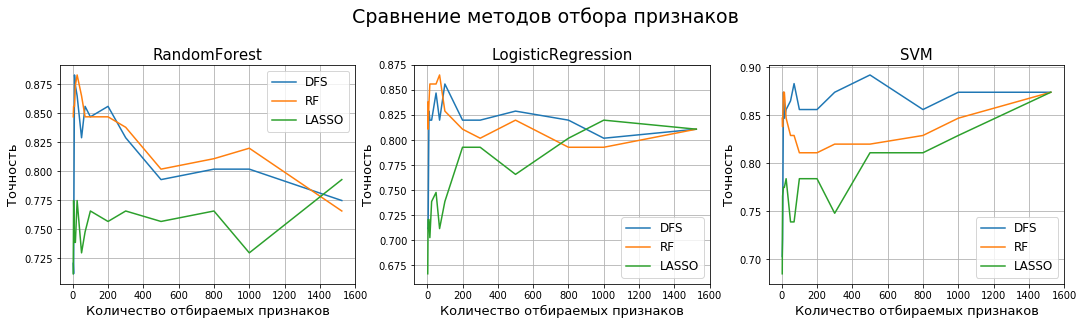

In [28]:
fig = plt.figure(figsize=(18, 4.5))
fig.suptitle('Сравнение методов отбора признаков', fontsize=19)
fig.tight_layout()
fig.subplots_adjust(top=0.8)

ax1 = fig.add_subplot(131)
ax1.plot(num_selected_features, rf_result['dfs'], label='DFS')
ax1.plot(num_selected_features, rf_result['rf'], label='RF')
ax1.plot(num_selected_features, rf_result['lasso'], label='LASSO')
ax1.set_xlabel('Количество отбираемых признаков', fontsize=13)
ax1.set_ylabel('Точность', fontsize=13)
ax1.set_title('RandomForest', fontsize=15)
ax1.legend(fontsize=12)
ax1.grid()

ax2 = fig.add_subplot(132)
ax2.plot(num_selected_features, lr_result['dfs'], label='DFS')
ax2.plot(num_selected_features, lr_result['rf'], label='RF')
ax2.plot(num_selected_features, lr_result['lasso'], label='LASSO')
ax2.set_xlabel('Количество отбираемых признаков', fontsize=13)
ax2.set_ylabel('Точность', fontsize=13)
ax2.set_title('LogisticRegression', fontsize=15)
ax2.legend(fontsize=12)
ax2.grid()

ax3 = fig.add_subplot(133)
ax3.plot(num_selected_features, svc_result['dfs'], label='DFS')
ax3.plot(num_selected_features, svc_result['rf'], label='RF')
ax3.plot(num_selected_features, svc_result['lasso'], label='LASSO')
ax3.set_xlabel('Количество отбираемых признаков', fontsize=13)
ax3.set_ylabel('Точность', fontsize=13)
ax3.set_title('SVM', fontsize=15)
ax3.legend(fontsize=12)
ax3.grid()

plt.savefig('results.png')

**Максимальная** точность для каждой модели отбора и финальной модели

In [29]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ['Модель отбора\Финальная модель', 'RandomForest', 'LogisticRegression', 'SVM']

table.add_row(['DFS', max(rf_result['dfs']), max(lr_result['dfs']), max(svc_result['dfs'])])
table.add_row(['RF', max(rf_result['rf']), max(lr_result['rf']), max(svc_result['rf'])])
table.add_row(['LASSO', max(rf_result['lasso']), max(lr_result['lasso']), max(svc_result['lasso'])])

table.align = 'c'
table.float_format = '.4'

print(table)

+--------------------------------+--------------+--------------------+--------+
| Модель отбора\Финальная модель | RandomForest | LogisticRegression |  SVM   |
+--------------------------------+--------------+--------------------+--------+
|              DFS               |    0.8829    |       0.8559       | 0.8919 |
|               RF               |    0.8829    |       0.8649       | 0.8739 |
|             LASSO              |    0.7928    |       0.8198       | 0.8739 |
+--------------------------------+--------------+--------------------+--------+


## Выводы

Как видно из графиков **RandomForest** даёт лучшие результаты чем **DFS** для *RandomForest* и *LogisticRegression*. При увеличении числа признаков результаты примерно совпадают, но отбирая малое количество признаков **RandomForest** оказывается лучше.

Если обратиться к лучшим результатам, то видно что **DFS** превзошёл **RandomForest** только для *SVM* причём на большем количестве признаков и только на 0.02. Возможно такие результаты связаны с маленьким объёмом обучающей выборки, который не позволил лучше обучить сеть.